# 4-CRU Mechanism Kinematic Calculation Handbook

In [1]:
from __future__ import print_function
import numpy as np
import numpy.matlib
import numpy.linalg as la
import math
from sympy import * # symbolic calculation for IK
#import transformations.py as tfs 
import transformations as tfs
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

# check the environment and directory of the notebook
import sys
sys.path

['',
 'C:\\Users\\Chawin Ophaswongse\\OneDrive\\MechE MS-PhD\\Jupyter_notebook\\4-CRU_mechnism_project\\4-CRU_mechanism_analysis',
 'C:\\ProgramData\\Anaconda3\\python37.zip',
 'C:\\ProgramData\\Anaconda3\\DLLs',
 'C:\\ProgramData\\Anaconda3\\lib',
 'C:\\ProgramData\\Anaconda3',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\Chawin Ophaswongse\\.ipython']

## Important Notes
1. This notebook must be run in conda environment (python 3 kernel)
2. Always put transformations.py in the same directory as this notebook

## Jupyter Notebook Tips and Tricks
1. https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
2. https://hub.packtpub.com/basics-jupyter-notebook-python/
3. Installing Python Kernel https://ipython.readthedocs.io/en/latest/install/kernel_install.html
4. Update Python 3.5 in Ubuntu 16.04 to 3.6+ http://ubuntuhandbook.org/index.php/2017/07/install-python-3-6-1-in-ubuntu-16-04-lts/

## Notes on [Transformation.py](https://github.com/ROAR-Lab-Spine/geometry/blob/melodic-devel/tf/src/tf/transformations.py)


1. Quaternions $q = ix+jy+kz+w$ are represented as $[x, y, z, w ]$= $[x_1, x_2, x_3, x_0]$.

## Notes on [SymPy’s documentation](https://docs.sympy.org/latest/index.html)

1. [Matrix Functions](https://docs.sympy.org/latest/modules/matrices/common.html?highlight=transpose#sympy.matrices.common.MatrixCommon.transpose)
2. [Matrix Operations](https://docs.sympy.org/latest/modules/matrices/matrices.html?highlight=matrix%20operation)
3. [Polynomial and Groebner bases¶](https://docs.sympy.org/latest/modules/polys/basics.html?highlight=polynomial%20solve)
4. Primary Decomposition

## Notes on SINGULAR
1. [Related Publications](https://www.singular.uni-kl.de/index.php/publications/singular-related-publications.html)

In [2]:
tf_init = tfs.identity_matrix()
# print tf_init
des_quat = tfs.quaternion_about_axis(0, (0, 0, 1))
des_xyz = np.array([0,0,0.1])
print(des_quat)
print(des_xyz)

[0. 0. 0. 1.]
[0.  0.  0.1]


In [3]:
# Set up Symbolic variables
X, Y, Z = symbols('X, Y, Z')
x_0, x_1, x_2, x_3 = symbols('x_0, x_1, x_2, x_3')
a, b, c, d = symbols('a, b, c, d')
h_1, h_2, h_3, h_4 = symbols('h_1, h_2, h_3, h_4')
r = symbols('r')

In [4]:
# Position of the C joint with respect to the base frame
r0_B1 = Matrix([a, -b, h_1, 1])
r1_C1 = Matrix([c, -d, 0, 1])

r0_B2 = Matrix([a, b, h_2, 1])
r1_C2 = Matrix([c, d, 0, 1])

r0_B3 = Matrix([-a, b, h_3, 1])
r1_C3 = Matrix([-c, d, 0, 1])

r0_B4 = Matrix([-a, -b, h_4, 1])
r1_C4 = Matrix([-c, -d, 0, 1])

In [5]:
R0_1 = Matrix([[x_0**2 + x_1**2 - x_2**2 - x_3**2, 2.0*(x_1*x_2 - x_0*x_3), 2.0*(x_0*x_2 + x_1*x_3)],
                [2.0*(x_0*x_3 + x_1*x_2),x_0**2 - x_1**2 + x_2**2 - x_3**2,2.0*(x_2*x_3 - x_0*x_1)],
                [2.0*(x_1*x_3 - x_0*x_2),2.0*(x_0*x_1 + x_2*x_3),x_0**2 - x_1**2 - x_2**2 + x_3**2]])
r0_1 = Matrix([X, Y, Z, 1.0])  
T0_1 = R0_1.col_join(zeros(1,3))
T0_1 = T0_1.row_join(r0_1)
T0_1

Matrix([
[x_0**2 + x_1**2 - x_2**2 - x_3**2,        -2.0*x_0*x_3 + 2.0*x_1*x_2,         2.0*x_0*x_2 + 2.0*x_1*x_3,   X],
[        2.0*x_0*x_3 + 2.0*x_1*x_2, x_0**2 - x_1**2 + x_2**2 - x_3**2,        -2.0*x_0*x_1 + 2.0*x_2*x_3,   Y],
[       -2.0*x_0*x_2 + 2.0*x_1*x_3,         2.0*x_0*x_1 + 2.0*x_2*x_3, x_0**2 - x_1**2 - x_2**2 + x_3**2,   Z],
[                                0,                                 0,                                 0, 1.0]])

In [6]:
# Vector along the U-U Rods
u0_1 = T0_1*r1_C1 - r0_B1
u0_2 = T0_1*r1_C2 - r0_B2
u0_3 = T0_1*r1_C3 - r0_B3
u0_4 = T0_1*r1_C4 - r0_B4

In [7]:
r0_ee_to_C2 = T0_1*r1_C2
r0_ee_to_C2 = r0_ee_to_C2.subs([(X, 0),(Y, 0),(Z, 0)])

In [8]:
# Scalar Triple Product 
f_5 = simplify(expand(u0_1.dot(u0_1))) - r**2
f_6 = simplify(expand(u0_2.dot(u0_2))) - r**2
f_7 = simplify(expand(u0_3.dot(u0_3))) - r**2
f_8 = simplify(expand(u0_4.dot(u0_4))) - r**2
f_9 = x_0**2+x_1**2+x_2**2+x_3**2-1.0

# Substitute Additional Mode Geometric Condition A
f_5A = f_5.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_6A = f_6.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_7A = f_7.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_8A = f_8.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)
f_9A = f_9.subs([(c, a),(x_2, 0),(x_3, 0),(X,0)],simultaneous=True)

f_6

X**2 - 2*X*a + 2*X*c*x_0**2 + 2*X*c*x_1**2 - 2*X*c*x_2**2 - 2*X*c*x_3**2 - 4.0*X*d*x_0*x_3 + 4.0*X*d*x_1*x_2 + Y**2 - 2*Y*b + 4.0*Y*c*x_0*x_3 + 4.0*Y*c*x_1*x_2 + 2*Y*d*x_0**2 - 2*Y*d*x_1**2 + 2*Y*d*x_2**2 - 2*Y*d*x_3**2 + Z**2 - 4.0*Z*c*x_0*x_2 + 4.0*Z*c*x_1*x_3 + 4.0*Z*d*x_0*x_1 + 4.0*Z*d*x_2*x_3 - 2*Z*h_2 + a**2 - 2*a*c*x_0**2 - 2*a*c*x_1**2 + 2*a*c*x_2**2 + 2*a*c*x_3**2 + 4.0*a*d*x_0*x_3 - 4.0*a*d*x_1*x_2 + b**2 - 4.0*b*c*x_0*x_3 - 4.0*b*c*x_1*x_2 - 2*b*d*x_0**2 + 2*b*d*x_1**2 - 2*b*d*x_2**2 + 2*b*d*x_3**2 + c**2*x_0**4 + 2*c**2*x_0**2*x_1**2 + 2.0*c**2*x_0**2*x_2**2 + 2.0*c**2*x_0**2*x_3**2 + c**2*x_1**4 + 2.0*c**2*x_1**2*x_2**2 + 2.0*c**2*x_1**2*x_3**2 + c**2*x_2**4 + 2*c**2*x_2**2*x_3**2 + c**2*x_3**4 + 4.0*c*h_2*x_0*x_2 - 4.0*c*h_2*x_1*x_3 + d**2*x_0**4 + 2.0*d**2*x_0**2*x_1**2 + 2*d**2*x_0**2*x_2**2 + 2.0*d**2*x_0**2*x_3**2 + d**2*x_1**4 + 2.0*d**2*x_1**2*x_2**2 + 2*d**2*x_1**2*x_3**2 + d**2*x_2**4 + 2.0*d**2*x_2**2*x_3**2 + d**2*x_3**4 - 4.0*d*h_2*x_0*x_1 - 4.0*d*h_2*x_2*x_3 +

In [9]:
f_9A_sq = f_9A*f_9A
f_9A_sq_expd = expand(f_9A_sq)
f_9A_sq

(x_0**2 + x_1**2 - 1.0)**2

In [10]:
f_9A_sq_expd.subs(-2.0*x_0**2-2.0*x_1**2, -2)

x_0**4 + 2*x_0**2*x_1**2 - 2.0*x_0**2 + x_1**4 - 2.0*x_1**2 + 1.0

In [11]:
f_9A_sq_expd

x_0**4 + 2*x_0**2*x_1**2 - 2.0*x_0**2 + x_1**4 - 2.0*x_1**2 + 1.0

In [12]:
f_5A = collect(f_5A, (X,Y,Z,r,a,b,c,d))
f_5A

Y**2 + Y*(2*b - 2*d*x_0**2 + 2*d*x_1**2) + Z**2 + Z*(-4.0*d*x_0*x_1 - 2*h_1) + a**2*(x_0**4 + 2*x_0**2*x_1**2 - 2*x_0**2 + x_1**4 - 2*x_1**2 + 1) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2*(x_0**4 + 2.0*x_0**2*x_1**2 + x_1**4) + 4.0*d*h_1*x_0*x_1 + h_1**2 - r**2

In [13]:
# eliminate the quaternion identity
f_5A = f_5A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_5A = f_5A.subs(f_9A_sq_expd-1.0,-1.0)
f_5A

Y**2 + Y*(2*b - 2*d*x_0**2 + 2*d*x_1**2) + Z**2 + Z*(-4.0*d*x_0*x_1 - 2*h_1) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 + 4.0*d*h_1*x_0*x_1 + h_1**2 - r**2

In [14]:
f_6A = collect(f_6A, (X,Y,Z,r,a,b,c,d))
f_6A = f_6A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_6A = f_6A.subs(f_9A_sq_expd-1.0,-1.0)
f_6A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_2) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_2*x_0*x_1 + h_2**2 - r**2

In [15]:
f_7A = collect(f_7A, (X,Y,Z,r,a,b,c,d))
f_7A = f_7A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_7A = f_7A.subs(f_9A_sq_expd-1.0,-1.0)
f_7A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_3) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_3*x_0*x_1 + h_3**2 - r**2

In [16]:
f_8A = collect(f_8A, (X,Y,Z,r,a,b,c,d))
f_8A = f_8A.subs(x_0**4+2.0*x_0**2*x_1**2+x_1**4, 1)
f_8A = f_8A.subs(f_9A_sq_expd-1.0,-1.0)
f_7A

Y**2 + Y*(-2*b + 2*d*x_0**2 - 2*d*x_1**2) + Z**2 + Z*(4.0*d*x_0*x_1 - 2*h_3) + b**2 + b*(-2*d*x_0**2 + 2*d*x_1**2) + d**2 - 4.0*d*h_3*x_0*x_1 + h_3**2 - r**2

# Inverse Kinematics (Schoenfiles Mode)

In [17]:
# Schonflies Mode
# T0_1_H1 = T0_1.subs([(x_1, 0),(x_2, 0)],simultaneous=True)
des_pose = tfs.identity_matrix()

f_5_H1 = f_5.subs([(X, des_xyz[0]),
                   (Y, des_xyz[1]),
                   (Z, des_xyz[2]),
                   (x_1, des_quat[0]),
                   (x_2, des_quat[1]),
                   (x_3, des_quat[2]),
                   (x_0, des_quat[3])],
                  simultaneous=True) 
h_1_sols = solve(f_5_H1, h_1)
h_1_sols[1]

sqrt(-a**2 + 2.0*a*c - b**2 + 2.0*b*d - c**2 - d**2 + r**2) + 0.1

In [18]:
h_2_sols = solve(f_6, h_2)
h_2_sols[1].subs([(x_1, 0),(x_2, 0)])
# We can change the signs of a,b,c,d corresponding to the position of each joint

Z + sqrt(-X**2 + 2.0*X*a - 2.0*X*c*x_0**2 + 2.0*X*c*x_3**2 + 4.0*X*d*x_0*x_3 - Y**2 + 2.0*Y*b - 4.0*Y*c*x_0*x_3 - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_3**2 - a**2 + 2.0*a*c*x_0**2 - 2.0*a*c*x_3**2 - 4.0*a*d*x_0*x_3 - b**2 + 4.0*b*c*x_0*x_3 + 2.0*b*d*x_0**2 - 2.0*b*d*x_3**2 - c**2*x_0**4 - 2.0*c**2*x_0**2*x_3**2 - c**2*x_3**4 - d**2*x_0**4 - 2.0*d**2*x_0**2*x_3**2 - d**2*x_3**4 + r**2)

# Inverse Kinematics (Additional Mode: Geometric A)

In [19]:
# Additional Mode (Geometric A)
g_1A = factor(f_5A - f_8A)
g_1A

1.0*(1.0*h_1 - 1.0*h_4)*(-2.0*Z + 4.0*d*x_0*x_1 + 1.0*h_1 + 1.0*h_4)

In [20]:
g_2A = factor(f_5A + f_8A)
g_2A

-1.0*(-2.0*Y**2 - 4.0*Y*b + 4.0*Y*d*x_0**2 - 4.0*Y*d*x_1**2 - 2.0*Z**2 + 8.0*Z*d*x_0*x_1 + 2.0*Z*h_1 + 2.0*Z*h_4 - 2.0*b**2 + 4.0*b*d*x_0**2 - 4.0*b*d*x_1**2 - 2.0*d**2 - 4.0*d*h_1*x_0*x_1 - 4.0*d*h_4*x_0*x_1 - 1.0*h_1**2 - 1.0*h_4**2 + 2.0*r**2)

In [21]:
g_3A = factor(f_6A - f_7A)
g_3A = g_3A .args[1]*(g_3A.args[0]*g_3A.args[2])
g_3A

(1.0*h_2 - 1.0*h_3)*(-2.0*Z - 4.0*d*x_0*x_1 + 1.0*h_2 + 1.0*h_3)

In [22]:
g_4A = expand(factor(f_6A + f_7A))
g_4A

2.0*Y**2 - 4.0*Y*b + 4.0*Y*d*x_0**2 - 4.0*Y*d*x_1**2 + 2.0*Z**2 + 8.0*Z*d*x_0*x_1 - 2.0*Z*h_2 - 2.0*Z*h_3 + 2.0*b**2 - 4.0*b*d*x_0**2 + 4.0*b*d*x_1**2 + 2.0*d**2 - 4.0*d*h_2*x_0*x_1 - 4.0*d*h_3*x_0*x_1 + 1.0*h_2**2 + 1.0*h_3**2 - 2.0*r**2

In [23]:
# Reduce to 3 Equations 
e_1A = expand(factor(g_2A.subs(h_1, h_4)))/2
e_1A

Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 + Z**2 - 4.0*Z*d*x_0*x_1 - 2.0*Z*h_4 + b**2 - 2.0*b*d*x_0**2 + 2.0*b*d*x_1**2 + d**2 + 4.0*d*h_4*x_0*x_1 + h_4**2 - 1.0*r**2

In [24]:
#***Choose the factor that does not lead to actuation singularity configuration
e_2A = g_3A.args[1]
e_2A

-2.0*Z - 4.0*d*x_0*x_1 + 1.0*h_2 + 1.0*h_3

In [25]:
e_3A = g_4A
e_3A
factor(e_3A)

-1.0*(-2.0*Y**2 + 4.0*Y*b - 4.0*Y*d*x_0**2 + 4.0*Y*d*x_1**2 - 2.0*Z**2 - 8.0*Z*d*x_0*x_1 + 2.0*Z*h_2 + 2.0*Z*h_3 - 2.0*b**2 + 4.0*b*d*x_0**2 - 4.0*b*d*x_1**2 - 2.0*d**2 + 4.0*d*h_2*x_0*x_1 + 4.0*d*h_3*x_0*x_1 - 1.0*h_2**2 - 1.0*h_3**2 + 2.0*r**2)

In [26]:
# solve for h_4 (=h_1), h_2, and h_3

# invs_kin_sols_geo_A = solve((e_1A, e_2A, e_3A), (h_2, h_3, h_4))
# invs_kin_sols_geo_A

h_1_h_4_sol = simplify(solve(e_1A, h_4))
print('h1 = ', h_1_h_4_sol[0], ' or ')
print(h_1_h_4_sol[1])

h1 =  Z - 2.0*d*x_0*x_1 - sqrt(-Y**2 - 2.0*Y*b + 2.0*Y*d*x_0**2 - 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)  or 
Z - 2.0*d*x_0*x_1 + sqrt(-Y**2 - 2.0*Y*b + 2.0*Y*d*x_0**2 - 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)


In [27]:
# Solving the Y position where h1 and h_4 can toggle up-down (h1 = h4 = Z)
determinant = -Y**2 - 2.0*Y*b + 2.0*Y*d*x_0**2 - 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2
Y_trans = solve(determinant, Y)
print(Y_trans)

[-b + d*x_0**2 - d*x_1**2 - sqrt(d**2*x_0**4 + 2.0*d**2*x_0**2*x_1**2 + d**2*x_1**4 - d**2 + r**2), -b + d*x_0**2 - d*x_1**2 + sqrt(d**2*x_0**4 + 2.0*d**2*x_0**2*x_1**2 + d**2*x_1**4 - d**2 + r**2)]


In [28]:
# https://stackoverflow.com/questions/53092738/eliminate-a-variable-to-relate-two-functions-in-python-using-sympy
# https://github.com/sympy/sympy/issues/2720
d_1A = factor(e_3A.subs(h_2, solve(e_2A, h_2)[0]))
h_3_sol = solve((d_1A,f_9A), h_3)

In [29]:
h_3_sol[0][0]

Z + 2.0*d*x_0*x_1 - sqrt(-Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)

In [30]:
h_2_sol = (solve(e_2A, h_2)[0]).subs(h_3, h_3_sol[0][0])
h_2_sol

1.0*Z + 2.0*d*x_0*x_1 + sqrt(-Y**2 + 2.0*Y*b - 2.0*Y*d*x_0**2 + 2.0*Y*d*x_1**2 - b**2 + 2.0*b*d*x_0**2 - 2.0*b*d*x_1**2 + 4.0*d**2*x_0**2*x_1**2 - d**2 + r**2)

# Forward Kinematics (Schoenfiles Mode)

# Trajectory Simulation 

Geometric Condition:  A
[a, b, c, d] =  [79.375, 79.375, 79.375, 32.878201513364424]  mm
r =  85.8  mm


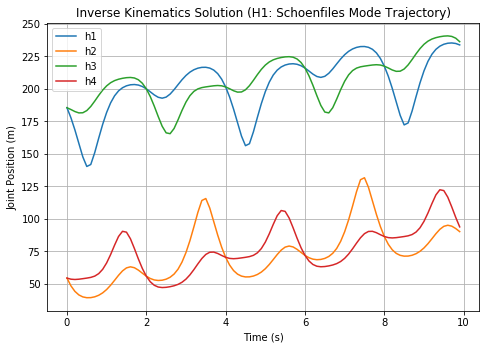

In [78]:
from __future__ import print_function
import numpy as np
import numpy.matlib
import numpy.linalg as la
import math
from sympy import * # symbolic calculation for IK
import transformations as tfs
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt

import Robot4CRU as robot4CRU
# create a robot 
robot = robot4CRU.Robot4CRU()
# Schoenflies Trajectory
dt = 0.1 # step size
T = np.arange(0, 10, dt)

tt = symbols('tt')
XxH1 = 15.0 + 15.0*cos(0.5 * np.pi * tt)
YyH1 = 15.0*sin(0.5 * np.pi * tt)
ZzH1 = 120.0 + 4 * tt
# PhiH1 = np.ones(len(T))*0.2
PhiH1 = 0.25*sin(np.pi * tt)

robot.operation_mode = "H1"

dof1 = lambdify(tt, XxH1, "numpy")
dof2 = lambdify(tt, YyH1, "numpy")
dof3 = lambdify(tt, ZzH1, "numpy")
dof4 = lambdify(tt, PhiH1, "numpy")

DOF1 = dof1(T)
DOF2 = dof2(T)
DOF3 = dof3(T)
DOF4 = dof4(T)

des_pose_4dof_traj = np.array([DOF1, DOF2, DOF3, DOF4])

# des_pose_4dof_traj = 
Hh1, TFtf1 = robot.solve_inv_kin_traj(des_pose_4dof_traj)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(T, Hh1[0, :], label='h1')
ax.plot(T, Hh1[1, :], label='h2')
ax.plot(T, Hh1[2, :], label='h3')
ax.plot(T, Hh1[3, :], label='h4')
ax.set_ylabel('Joint Position (m)')
ax.set_xlabel('Time (s)')
ax.set_title('Inverse Kinematics Solution (H1: Schoenfiles Mode Trajectory)')
ax.legend()
plt.grid(True)
plt.show()

In [79]:
# https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html
#from __future__ import print_function 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def traj_H1(u):
    Xx = DOF1
    Yy = DOF2
    Zz = DOF3

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(30, 30)
    ax.plot(Xx, Yy, Zz, label='des traj')
    ax.scatter(Xx[u], Yy[u], Zz[u], label='des pos')
    
    # manually set joint position and tranformation mat of the robot
    robot.tf_mat = TFtf1[u, :, :]
    robot.joint_pos = Hh1[:,u]
    
    # draw robot
    robot.drawRobot(ax)
    
    plt.show()
    
    print("t =", T[u], " sec")

interact(traj_H1, u=(0, len(T)-1));

interactive(children=(IntSlider(value=49, description='u', max=99), Output()), _dom_classes=('widget-interact'…

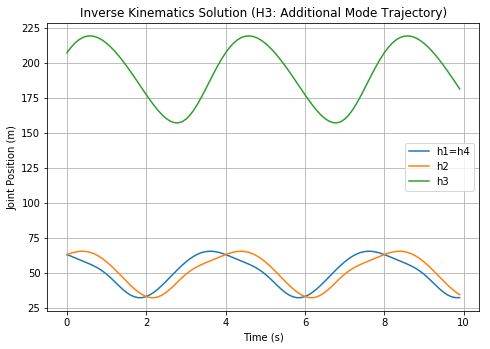

In [33]:
# H3 geometric A Trajectory
robot.operation_mode = "H3"
dt3a = 0.1
tt3a = np.arange(0, 10, dt3a)
Xx3a = np.ones(len(tt3a))*0
Yy3a = 15.0*np.sin(0.5 * np.pi * tt3a)
Zz3a = 120.0 + 15.0*np.cos(0.5 * np.pi * tt3a)
# Theta3a = np.ones(len(tt3a))*0.5
Theta3a = 0.5*np.sin(0.5 * np.pi * tt3a)

des_pose_4dof_traj = np.array([Xx3a, Yy3a, Zz3a, Theta3a])
Hh3a, TFtf3a = robot.solve_inv_kin_traj(des_pose_4dof_traj)
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(tt3a, Hh3a[0,:], label='h1=h4')
ax.plot(tt3a, Hh3a[1,:], label='h2')
ax.plot(tt3a, Hh3a[2,:], label='h3')
# ax.plot(tt3a, Hh3a[3,:], label='h4')
ax.set_ylabel('Joint Position (m)')
ax.set_xlabel('Time (s)')
ax.set_title('Inverse Kinematics Solution (H3: Additional Mode Trajectory)')
ax.legend()
plt.grid(True)
plt.show()

In [34]:
def traj_H3(u):
    #plt.ion() # don't need to use plt.show()
    t3a = tt3a[u]
    X3a = 0
    Y3a = 15.0*np.sin(0.5 * np.pi * t3a)
    Z3a = 120.0 + 15.0*np.cos(0.5 * np.pi * t3a)
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.view_init(30, 30)
    ax.plot(Xx3a, Yy3a, Zz3a, label='des traj')
    ax.scatter(X3a, Y3a, Z3a, label='des pos')
    
    # manually set joint position of the robot
    robot.joint_pos = Hh3a[:,u]
    robot.tf_mat = TFtf3a[u, :, :]
    
    # draw robot
    robot.drawRobot(ax)
    plt.show()
    
    print("t =", t3a, " sec")

interact(traj_H3, u=(0, len(tt3a)-1));

interactive(children=(IntSlider(value=49, description='u', max=99), Output()), _dom_classes=('widget-interact'…

[205.26673907  64.8938043  220.80846024  88.50270561]
[[ 9.97017374e-01  7.71774265e-02  0.00000000e+00  1.26534830e+01]
 [-7.71774265e-02  9.97017374e-01  0.00000000e+00  1.48153251e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.40400000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
real roots of tp:  [ 5.17706496e+01  4.55319405e+01 -2.19626045e-02 -1.93159639e-02]
[[ 9.97017374e-01  7.71774265e-02  0.00000000e+00  1.26534830e+01]
 [-7.71774265e-02  9.97017374e-01  0.00000000e+00  1.48153251e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.40400000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
r1=  85.79999999833171
r2=  85.7999999983314
r3=  85.7999999983314
r4=  85.7999999983317
[[ 9.96144872e-01  8.77233946e-02  0.00000000e+00 -1.35240702e+01]
 [-8.77233946e-02  9.96144872e-01  0.00000000e+00  1.32562397e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  1.39829045e+02]
 [ 0.00000000e+00  0.00000000e+00

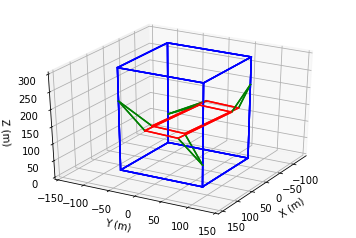

In [81]:
print(robot.joint_pos)
print(robot.tf_mat)
import forward_kin_4CRU as fwd_kin

rr = robot.forward_kinematics()
print('real roots of tp: ', rr)
np.real(rr)


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(30, 30)

for i in range(len(rr)):
    
    # manually set joint position and tranformation mat of the robot
    robot.tf_mat = robot.tf_mat_from_tp(rr[i])
    print(robot.tf_mat)
    # draw robot
    robot.drawRobot(ax)
    
plt.show()


# TO DO...
1. Add interface for choosing operation mode switching at  and geometric condition 
2. choose inverse kinematic solution cases corresponding to sigularity for each mode
3. Add plot of cureent inverse kinematic solution (and potential trajectory when switching modes)
4. plot the singularity locus in the joint space and Cartesian Space
5. Clean up codes 